In [1]:
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import random
import matplotlib as mpl
import os
import gc
import pandas as pd
import csv
from numpy import *
from torch.utils.tensorboard import SummaryWriter
from datetime import date
import builtins
# mpl.rcParams['figure.dpi'] = 180

In [2]:
features = np.load('./tensile_features.npy', allow_pickle=True)
output_properties = np.load('./tensile_output.npy', allow_pickle=True)
output_properties = output_properties.reshape((-1,1))

print('Input features:', features.shape)
print('output:', output_properties.shape)

Input features: (221, 708)
output: (221, 1)


In [3]:
## output data
is_available = (np.isnan(output_properties[:,0])==False)
index = np.where(is_available== True)
output_y = output_properties[index,0]
output_y = output_y.T
input = features[index,:][0]

print('input:', input.shape)
print('Output shape', output_y.shape)

input: (203, 708)
Output shape (203, 1)


In [4]:
## Split the train and test
x_test = np.load('./x_test_tensile.npy', allow_pickle=True)
y_test = x_test
n_samples_test = np.shape(x_test)[0]


In [5]:
## Dataloader
batch_size = 32
class spiderdataset(Dataset) :
    def __init__(self,x_3, y, n_samples) :
        # data loading
        self.x3 = x_3
        self.y = y 
        self.n_samples = n_samples
        
        
    def __getitem__(self,index) :
        return self.x3[index], self.y[index]

    def __len__(self) :    
        return self.n_samples      

test_dataset = spiderdataset(input[x_test,:],output_y[x_test,:],n_samples_test)


test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=1)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN + RNN Model
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        
        # nn layers
        
        self.nn = nn.Sequential(nn.Linear(2014,128),
                                nn.ReLU(),
                                nn.Linear(128,64),
                                nn.ReLU(),
                                nn.Linear(64,24),
                                nn.ReLU(),
                                nn.Linear(24,12),
                                nn.ReLU(),
                                nn.Linear(12,12),
                                nn.ReLU(),
                                nn.Linear(12,8),
                                nn.ReLU(),
                                nn.Linear(8,8),
                                nn.ReLU(),
                                nn.Linear(8,1)
                                )
    

        
    def forward(self, x):
        # out3 = x3
        # out5 = x5
        out = self.nn(x)

        return out


epoch_check = 181 ##CHANGE
model = torch.load('./model/epoch_'+ str(epoch_check) + '.pth', map_location='cuda')
model.eval().to(device)

network(
  (nn): Sequential(
    (0): Linear(in_features=708, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=24, bias=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=12, bias=True)
    (7): ReLU()
    (8): Linear(in_features=12, out_features=12, bias=True)
    (9): ReLU()
    (10): Linear(in_features=12, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=8, bias=True)
    (13): ReLU()
    (14): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [7]:
def weighted_loss(iter_y, iter_y_pred, s= torch.tensor(0.51), m= torch.tensor(1.18)):
    s= s.to(device)
    m = m.to(device)
    inverse_weight = (1/(2.5*s))*torch.exp(-0.5*(iter_y-m)**2/s**2)
    loss = (iter_y - iter_y_pred)*(iter_y - iter_y_pred)*(1/inverse_weight)
    # print(loss.shape)
    loss = torch.mean(loss)
    # loss = loss.dtype(torch.float32)
    return loss

In [8]:
actual_prop = torch.zeros((n_samples_test,1)).to(device)
predicted_prop = torch.zeros((n_samples_test,1)).to(device)
count = 0
with torch.no_grad():
    valid_loss = 0.0
    for j, (i_x,iter_y) in enumerate(test_loader):
        # parameters = torch.reshape(parameters,(len(parameters),))
        i_x = i_x.to(device).type(dtype=torch.float32)
        # print(iter_y.shape) 
        iter_y = iter_y.to(device).type(dtype=torch.float32)

        # forward pass    
        iter_y_pred = model(i_x)
        size = iter_y_pred.shape[0]
        actual_prop[count:count+size,:] = iter_y
        predicted_prop[count:count+size,:] = iter_y_pred
        count += size
actual_prop = actual_prop.to('cpu').numpy()
predicted_prop = predicted_prop.to('cpu').numpy()


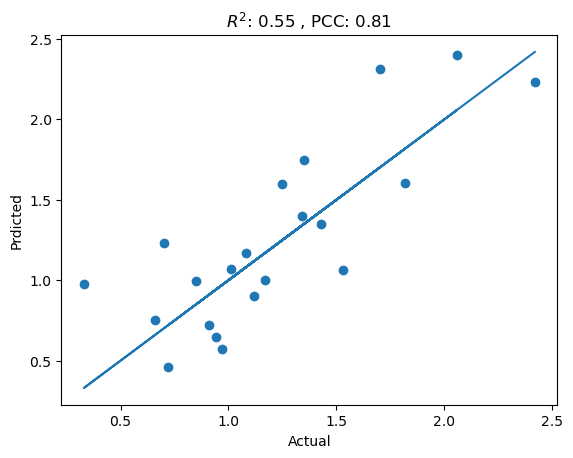

In [9]:
plt.scatter(actual_prop, predicted_prop)
plt.plot(actual_prop, actual_prop)
plt.xlabel('Actual')
plt.ylabel('Prdicted')
pcc = round(np.corrcoef(actual_prop.reshape((1,len(actual_prop))), predicted_prop.reshape((1,len(actual_prop))))[0,1],2)
plt.title(f'$R^2$: {round(r2_score(actual_prop, predicted_prop),2)} , PCC: {pcc}')
# plt.title(f'{np.corrcoef(actual_prop.reshape((1,len(actual_prop))), predicted_prop.reshape((1,len(actual_prop))))[0,1]}')
plt.show()